In [1]:
# Import the libraries
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from utils import train
from utils import save_load
from utils import plot
from utils import tensor
from itertools import combinations
import os

Using TensorFlow backend.


In [6]:
import tushare as ts
def get_data(token, ts_code, start_date, end_date, save_path):
    '''
    INPUT:
    token - string, personal tushare access token
    ts_code - string, stock code of SH
    start_date - string
    end_date - string
    save_path - string, csv file path to save
    
    OUTPUT:     
    df - pandas dataframe
    
    Description:
    Get one daily stock data from tushare api and save to specified path
        
    '''
    ts.set_token(token)
    pro = ts.pro_api()
    df = pro.query('daily', ts_code=ts_code, start_date=start_date, end_date=end_date)
    df = df.iloc[::-1]
    df.rename(columns={'trade_date': 'date'}, inplace=True)
    # df = df.set_index('date')
    df = df.loc[:, ['date','open', 'high', 'low', 'close', 'vol', 'amount']]
    # df.to_csv(save_path, index_label="date")
    df.to_csv(save_path)
    
    return df

In [7]:
# get data,load data and check the 1st ten rows, 78d6
df = get_data('77bd3efe782187c3356cf64a04479f16758d00f63abf096f54a4aac3', '600036.SH', '20100101', '20200821', "data/stock_cmb.csv")
df.head(10)

,date,open,high,low,close,vol,amount
2564,20100104,17.93,18.11,17.66,17.71,746135.58,1332370.091
2563,20100105,17.71,18.00,17.34,17.73,914013.73,1615349.974
2562,20100106,17.69,17.69,17.31,17.36,774277.06,1348702.948
2561,20100107,17.33,17.43,16.78,16.91,1019431.96,1742282.280
2560,20100108,16.88,16.98,16.68,16.91,803598.62,1351767.271
2559,20100111,17.88,17.91,16.80,16.94,1465692.50,2530625.181
2558,20100112,16.88,17.17,16.45,17.07,1121898.32,1879278.148
2557,20100113,16.52,16.70,15.97,16.15,2052232.76,3344313.047
2556,20100114,16.20,16.35,15.95,16.33,1247175.72,2011436.062
2555,20100115,16.27,16.46,16.03,16.31,873021.99,1417365.938


In [8]:
# drop data with NA
df = df.dropna()

In [9]:
'''
predict closing price of dataset using neural network using 
single attribute. 
Input to the model is the open price trend and the output of the 
model is the closing price of the stock.
'''

split_ratio = 0.8
epochs = 90
df_train = df[:int(len(df)*split_ratio)]
df_test = df[int(len(df)*split_ratio):]

# taking input set using open price and close price column
columns = [1, 4]

# important parameters
timestep = 60
no_of_feature = 1
input_col = [0]
output_col = [1]

# creating minmax scaler object
input_set = df.iloc[:, columns].values
sc_input = MinMaxScaler(feature_range = (0,1))
sc_input.fit(input_set)
sc_output = MinMaxScaler(feature_range = (0,1))
sc_output.fit(input_set[:,output_col]) 

# creating training set
training_set = df_train.iloc[:, columns].values
training_set_scaled = sc_input.transform(training_set)

X_train, y_train = tensor.create_tensor(training_set_scaled, timestep, input_col,\
                                        output_col, no_of_feature)

# creating testing set
testing_set = df_test.iloc[:, columns].values

# concatenating additional 60 days data from training set
x1 = pd.DataFrame(training_set[len(training_set)-timestep:])
x2 = pd.DataFrame(testing_set)
testing_set = np.array(pd.concat([x1, x2]))
testing_set_scaled = sc_input.transform(testing_set)

X_test, y_test = tensor.create_tensor(testing_set_scaled, timestep, input_col, \
                                      output_col, no_of_feature)

model = train.training(X_train, y_train, no_of_feature, epochs)



Epoch 1/90
1992/1992 [==============================] - 42s 21ms/step - loss: 0.0066
Epoch 2/90
1992/1992 [==============================] - 37s 19ms/step - loss: 0.0015
Epoch 3/90
1992/1992 [==============================] - 39s 20ms/step - loss: 0.0014
Epoch 4/90
1992/1992 [==============================] - 37s 19ms/step - loss: 0.0014
Epoch 5/90
1992/1992 [==============================] - 37s 18ms/step - loss: 0.0015
Epoch 6/90
1992/1992 [==============================] - 37s 18ms/step - loss: 0.0015
Epoch 7/90
1992/1992 [==============================] - 37s 18ms/step - loss: 0.0012
Epoch 8/90
1992/1992 [==============================] - 37s 18ms/step - loss: 0.0011
Epoch 9/90
1992/1992 [==============================] - 37s 19ms/step - loss: 0.0012
Epoch 10/90
1992/1992 [==============================] - 37s 19ms/step - loss: 0.0011
Epoch 11/90
1992/1992 [==============================] - 37s 18ms/step - loss: 0.0011
Epoch 12/90
1992/1992 [==============================] - 37s 18

In [10]:
# single_attribute path
path_name = "./model/single_attribute"

# Save the model
save_load.save_model(path_name, model)

Saved model to disk


Loaded model from disk
R2 Score :  0.9934046927508628
MSE Score :  0.21415755247793297


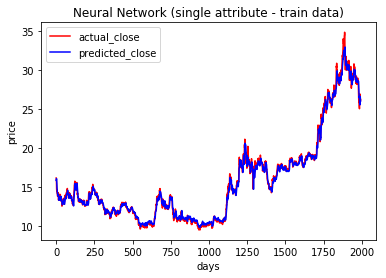

R2 Score :  0.7932951365090777
MSE Score :  2.799302106093408


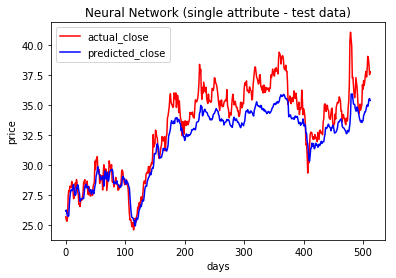

In [11]:
# load the model
model = save_load.load_model(path_name)

# predic: using the training data
pred_train_scaled = model.predict(X_train)

# rescaling the predictions (train data)
train_predict = sc_output.inverse_transform(pred_train_scaled)
train_actual = sc_output.inverse_transform(y_train) 

print('R2 Score : ', r2_score(train_actual, train_predict))
print('MSE Score : ', mean_squared_error(train_actual, train_predict))

plot.time_series_plot(train_actual, train_predict, 'red', 'blue', 'actual_close', \
                 'predicted_close', 'days', 'price', \
                 'Neural Network (single attribute - train data)')


# predict using test data
pred_test_scaled = model.predict(X_test)

# rescale for predictions (test data)
test_predict = sc_output.inverse_transform(pred_test_scaled)
test_actual = sc_output.inverse_transform(y_test)

print('R2 Score : ', r2_score(test_actual, test_predict))
print('MSE Score : ', mean_squared_error(test_actual, test_predict))

plot.time_series_plot(test_actual, test_predict, 'red', 'blue', 'actual_close', \
                 'predicted_close', 'days', 'price', \
                 'Neural Network (single attribute - test data)')

In [12]:
# save the results in excel format
date = pd.DataFrame(df_test['date']).reset_index(drop=True)
actual_price_df = pd.DataFrame(test_actual).round(3)
predict_price_df = pd.DataFrame(test_predict).round(3)
combined_df = pd.concat([date, actual_price_df, predict_price_df], axis = 1 )
combined_df.columns = ['date','actual_close', 'predicted_close']
combined_df.to_excel('./result/single_attribute/result.xlsx', index = False)

In [14]:
'''
search hyperparameters to get the best fit of hyperparameters.
'''

# creating minmax scaler object
input_set = df.iloc[:, columns].values
sc_input = MinMaxScaler(feature_range = (0,1))
sc_input.fit(input_set)
sc_output = MinMaxScaler(feature_range = (0,1))
sc_output.fit(input_set[:,output_col])

# creating training set
training_set = df_train.iloc[:, columns].values
training_set_scaled = sc_input.transform(training_set)

# hyperparameters
neurons = [5, 60, 80] 
optimiser = ['adam', 'rmsprop']
# activation = ['tanh', 'relu', 'sigmoid']
activation = ['relu', 'sigmoid']

count = 0
for neuron in neurons:
    # creating 3d tensor
    X_train, y_train = tensor.create_tensor(training_set_scaled, neuron, \
                                            input_col, output_col, no_of_feature)
    for optim in optimiser:
        for func in activation:
            # fitting the model
            model = train.training(X_train, y_train, no_of_feature, epochs, \
                                   func, optim)
            
            # Saving the model
            path_name = "./model/hyperParaModels" + "/" + str(count)
            os.mkdir(path_name)
            save_load.save_model(path_name, model)
            count = count + 1                

path_name = "./model/hyperParaModels" 


Epoch 1/90
2047/2047 [==============================] - 7s 4ms/step - loss: 0.0188A: 1s - l
Epoch 2/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0027
Epoch 3/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0022
Epoch 4/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0017
Epoch 5/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0016
Epoch 6/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0016
Epoch 7/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 8/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 9/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 10/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 11/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 12/90
2047/2047 [==============================] - 4s 2ms/step - loss:

2047/2047 [==============================] - 4s 2ms/step - loss: 0.0017
Epoch 5/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0015
Epoch 6/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 7/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 8/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 9/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 10/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 11/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 12/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 13/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 14/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 15/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 16/

2047/2047 [==============================] - 4s 2ms/step - loss: 0.0020
Epoch 9/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0015
Epoch 10/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0017
Epoch 11/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0015
Epoch 12/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0016
Epoch 13/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 14/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 15/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 16/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 17/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 18/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0014
Epoch 19/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch

2047/2047 [==============================] - 4s 2ms/step - loss: 0.0015
Epoch 14/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 15/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 16/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 17/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0013
Epoch 18/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 19/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 20/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 21/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0010
Epoch 22/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 23/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0011
Epoch 24/90
2047/2047 [==============================] - 4s 2ms/step - loss: 0.0011
Epoc

1992/1992 [==============================] - 36s 18ms/step - loss: 9.3505e-04
Epoch 18/90
1992/1992 [==============================] - 36s 18ms/step - loss: 9.3398e-04
Epoch 19/90
1992/1992 [==============================] - 36s 18ms/step - loss: 0.0011
Epoch 20/90
1992/1992 [==============================] - 36s 18ms/step - loss: 0.0010
Epoch 21/90
1992/1992 [==============================] - 36s 18ms/step - loss: 9.6939e-04
Epoch 22/90
1992/1992 [==============================] - 37s 18ms/step - loss: 8.1693e-04
Epoch 23/90
1992/1992 [==============================] - 37s 18ms/step - loss: 8.6042e-04
Epoch 24/90
1992/1992 [==============================] - 37s 18ms/step - loss: 8.7904e-04
Epoch 25/90
1992/1992 [==============================] - 36s 18ms/step - loss: 8.0140e-04
Epoch 26/90
1992/1992 [==============================] - 36s 18ms/step - loss: 7.7627e-04
Epoch 27/90
1992/1992 [==============================] - 36s 18ms/step - loss: 0.0010
Epoch 28/90
1992/1992 [===========

Epoch 19/90
1992/1992 [==============================] - 38s 19ms/step - loss: 9.9493e-04
Epoch 20/90
1992/1992 [==============================] - 41s 21ms/step - loss: 0.0010
Epoch 21/90
1992/1992 [==============================] - 41s 21ms/step - loss: 9.0326e-04
Epoch 22/90
1992/1992 [==============================] - 42s 21ms/step - loss: 8.8936e-04
Epoch 23/90
1992/1992 [==============================] - 42s 21ms/step - loss: 8.6417e-04
Epoch 24/90
1992/1992 [==============================] - 42s 21ms/step - loss: 8.3899e-04
Epoch 25/90
1992/1992 [==============================] - 41s 21ms/step - loss: 8.4589e-04
Epoch 26/90
1992/1992 [==============================] - 42s 21ms/step - loss: 7.5678e-04
Epoch 27/90
1992/1992 [==============================] - 41s 21ms/step - loss: 7.0460e-04
Epoch 28/90
1992/1992 [==============================] - 42s 21ms/step - loss: 8.4588e-04
Epoch 29/90
1992/1992 [==============================] - 44s 22ms/step - loss: 8.7516e-04
Epoch 30/90
19

1992/1992 [==============================] - 36s 18ms/step - loss: 0.0010
Epoch 21/90
1992/1992 [==============================] - 36s 18ms/step - loss: 0.0011
Epoch 22/90
1992/1992 [==============================] - 36s 18ms/step - loss: 0.0012
Epoch 23/90
1992/1992 [==============================] - 36s 18ms/step - loss: 0.0010
Epoch 24/90
1992/1992 [==============================] - 36s 18ms/step - loss: 0.0011
Epoch 25/90
1992/1992 [==============================] - 36s 18ms/step - loss: 0.0010
Epoch 26/90
1992/1992 [==============================] - 36s 18ms/step - loss: 9.6504e-04
Epoch 27/90
1992/1992 [==============================] - 36s 18ms/step - loss: 9.8075e-04
Epoch 28/90
1992/1992 [==============================] - 36s 18ms/step - loss: 8.8966e-04
Epoch 29/90
1992/1992 [==============================] - 36s 18ms/step - loss: 9.9188e-04
Epoch 30/90
1992/1992 [==============================] - 36s 18ms/step - loss: 8.8458e-04
Epoch 31/90
1992/1992 [=======================

1992/1992 [==============================] - 44s 22ms/step - loss: 8.5909e-04
Epoch 23/90
1992/1992 [==============================] - 46s 23ms/step - loss: 8.2284e-04
Epoch 24/90
1992/1992 [==============================] - 39s 19ms/step - loss: 8.5929e-04
Epoch 25/90
1992/1992 [==============================] - 38s 19ms/step - loss: 8.1446e-04
Epoch 26/90
1992/1992 [==============================] - 39s 19ms/step - loss: 7.6792e-04
Epoch 27/90
1992/1992 [==============================] - 38s 19ms/step - loss: 8.1767e-04
Epoch 28/90
1992/1992 [==============================] - 38s 19ms/step - loss: 7.9727e-04
Epoch 29/90
1992/1992 [==============================] - 36s 18ms/step - loss: 7.3431e-04
Epoch 30/90
1992/1992 [==============================] - 36s 18ms/step - loss: 8.4049e-04
Epoch 31/90
1992/1992 [==============================] - 37s 18ms/step - loss: 7.3021e-04
Epoch 32/90
1992/1992 [==============================] - 41s 20ms/step - loss: 7.2522e-04
Epoch 33/90
1992/1992 

1972/1972 [==============================] - 50s 25ms/step - loss: 0.0010
Epoch 24/90
1972/1972 [==============================] - 49s 25ms/step - loss: 9.3190e-04
Epoch 25/90
1972/1972 [==============================] - 49s 25ms/step - loss: 9.2292e-04
Epoch 26/90
1972/1972 [==============================] - 50s 25ms/step - loss: 8.5082e-04
Epoch 27/90
1972/1972 [==============================] - 49s 25ms/step - loss: 9.0713e-04
Epoch 28/90
1972/1972 [==============================] - 52s 26ms/step - loss: 9.1259e-04
Epoch 29/90
1972/1972 [==============================] - 51s 26ms/step - loss: 8.3827e-04
Epoch 30/90
1972/1972 [==============================] - 50s 25ms/step - loss: 8.0243e-04
Epoch 31/90
1972/1972 [==============================] - 50s 25ms/step - loss: 7.4266e-04
Epoch 32/90
1972/1972 [==============================] - 51s 26ms/step - loss: 7.3559e-04
Epoch 33/90
1972/1972 [==============================] - 49s 25ms/step - loss: 8.3435e-04
Epoch 34/90
1972/1972 [===

Epoch 25/90
1972/1972 [==============================] - 51s 26ms/step - loss: 0.0016
Epoch 26/90
1972/1972 [==============================] - 52s 26ms/step - loss: 0.0016
Epoch 27/90
1972/1972 [==============================] - 51s 26ms/step - loss: 0.0015
Epoch 28/90
1972/1972 [==============================] - 52s 26ms/step - loss: 0.0015
Epoch 29/90
1972/1972 [==============================] - 52s 26ms/step - loss: 0.0014
Epoch 30/90
1972/1972 [==============================] - 51s 26ms/step - loss: 0.0013
Epoch 31/90
1972/1972 [==============================] - 51s 26ms/step - loss: 0.0013
Epoch 32/90
1972/1972 [==============================] - 51s 26ms/step - loss: 0.0014
Epoch 33/90
1972/1972 [==============================] - 51s 26ms/step - loss: 0.0013
Epoch 34/90
1972/1972 [==============================] - 51s 26ms/step - loss: 0.0012
Epoch 35/90
1972/1972 [==============================] - 51s 26ms/step - loss: 0.0013
Epoch 36/90
1972/1972 [==============================]

1972/1972 [==============================] - 49s 25ms/step - loss: 9.8072e-04
Epoch 29/90
1972/1972 [==============================] - 49s 25ms/step - loss: 9.8299e-04
Epoch 30/90
1972/1972 [==============================] - 55s 28ms/step - loss: 9.2226e-04
Epoch 31/90
1972/1972 [==============================] - 53s 27ms/step - loss: 9.1189e-04
Epoch 32/90
1972/1972 [==============================] - 53s 27ms/step - loss: 9.5531e-04
Epoch 33/90
1972/1972 [==============================] - 51s 26ms/step - loss: 9.3620e-04
Epoch 34/90
1972/1972 [==============================] - 51s 26ms/step - loss: 8.5678e-04
Epoch 35/90
1972/1972 [==============================] - 51s 26ms/step - loss: 9.2895e-04
Epoch 36/90
1972/1972 [==============================] - 51s 26ms/step - loss: 8.2698e-04
Epoch 37/90
1972/1972 [==============================] - 51s 26ms/step - loss: 8.9281e-04
Epoch 38/90
1972/1972 [==============================] - 50s 26ms/step - loss: 8.1547e-04
Epoch 39/90
1972/1972 

1972/1972 [==============================] - 52s 27ms/step - loss: 7.2672e-04
Epoch 30/90
1972/1972 [==============================] - 51s 26ms/step - loss: 7.8010e-04
Epoch 31/90
1972/1972 [==============================] - 52s 26ms/step - loss: 7.1506e-04
Epoch 32/90
1972/1972 [==============================] - 50s 26ms/step - loss: 7.4102e-04
Epoch 33/90
1972/1972 [==============================] - 51s 26ms/step - loss: 6.7352e-04
Epoch 34/90
1972/1972 [==============================] - 52s 26ms/step - loss: 7.2922e-04
Epoch 35/90
1972/1972 [==============================] - 50s 25ms/step - loss: 6.7839e-04
Epoch 36/90
1972/1972 [==============================] - 52s 26ms/step - loss: 6.4317e-04
Epoch 37/90
1972/1972 [==============================] - 52s 26ms/step - loss: 6.7473e-04
Epoch 38/90
1972/1972 [==============================] - 52s 26ms/step - loss: 6.4133e-04
Epoch 39/90
1972/1972 [==============================] - 52s 26ms/step - loss: 6.6221e-04
Epoch 40/90
1972/1972 

Loaded model from disk
r2 :  0.1766904789018282
mse :  11.149675133203047


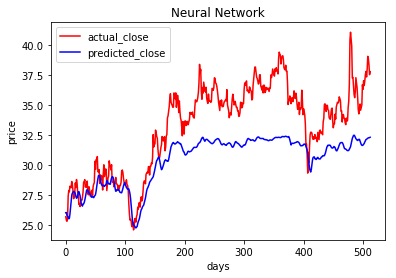

Loaded model from disk
r2 :  0.3422540760756676
mse :  8.90752892322051


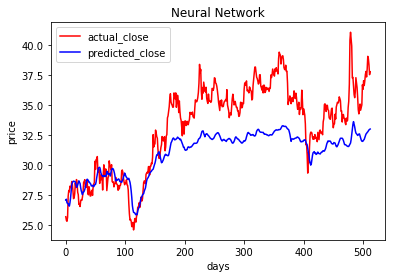

Loaded model from disk
r2 :  0.2231722366107568
mse :  10.520195593863415


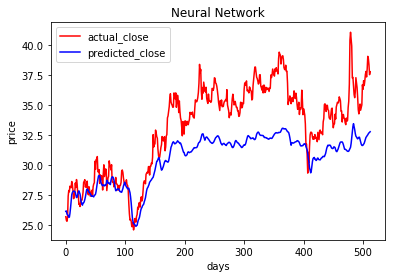

Loaded model from disk
r2 :  0.2544108336128501
mse :  10.097146668441283


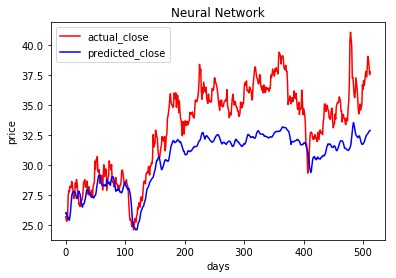

Loaded model from disk
r2 :  0.9190394523786541
mse :  1.0964088006417994


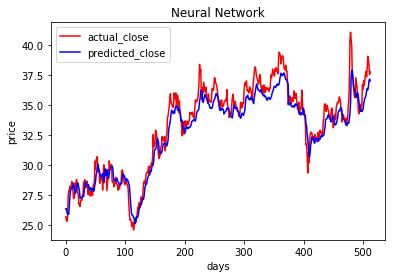

Loaded model from disk
r2 :  0.8923752611245956
mse :  1.4575088031970926


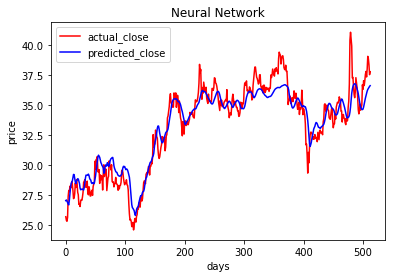

Loaded model from disk
r2 :  0.7119368709164671
mse :  3.9010970052323115


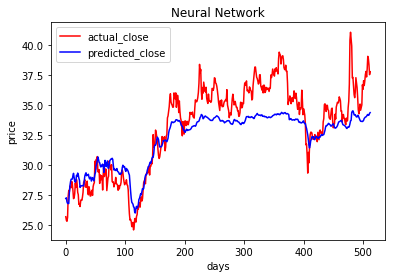

Loaded model from disk
r2 :  -0.06011265787509412
mse :  14.356583322561034


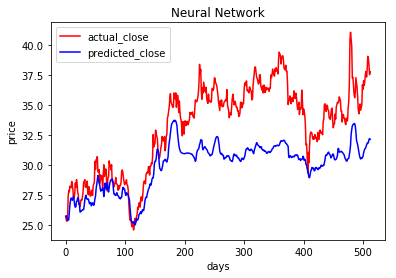

Loaded model from disk
r2 :  0.7990992076261899
mse :  2.7207004310884955


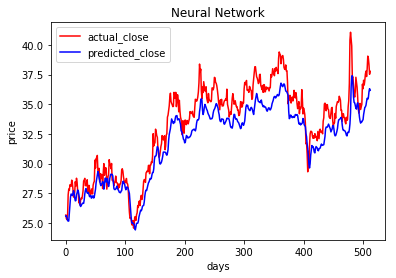

Loaded model from disk
r2 :  0.562934613014438
mse :  5.918961158564826


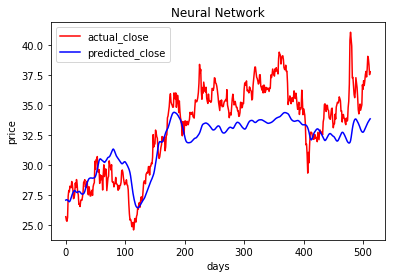

Loaded model from disk
r2 :  0.8450428014876212
mse :  2.0985089795387704


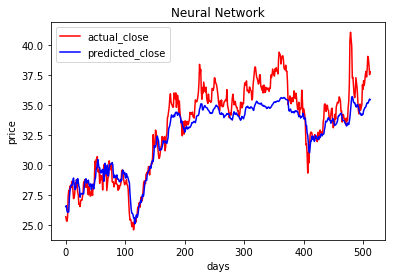

Loaded model from disk
r2 :  0.34494798766231116
mse :  8.871046606110193


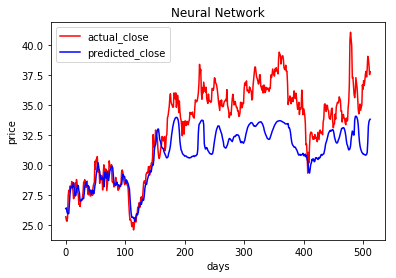

In [15]:
## for loop to search final hyperparameters

results = pd.DataFrame(columns=['neuron', 'optim', 'activation', 'r2_score', 'MSE'])
count = 0
for neuron in neurons:
    # create testing set
    testing_set = df_test.iloc[:, columns].values
    
    # concatenate additional 60 days data from training set
    x1 = pd.DataFrame(training_set[len(training_set)-neuron:])
    x2 = pd.DataFrame(testing_set)
    testing_set = np.array(pd.concat([x1, x2]))
    testing_set_scaled = sc_input.transform(testing_set)
    
    # creating 3d tensor
    X_test, y_test = tensor.create_tensor(testing_set_scaled, neuron, input_col,\
                                          output_col, no_of_feature)
    for optim in optimiser:
        for func in activation:
            # load model
            model = save_load.load_model(path_name + "/" + str(count))
            
            # predict using testing data
            pred_test_scaled = model.predict(X_test)
            
            # rescale the predictions
            test_predict = sc_output.inverse_transform(pred_test_scaled)
            test_actual = sc_output.inverse_transform(y_test)
            
            # score
            model_accuracy_r2 = r2_score(test_actual, test_predict)
            model_accuracy_mse = mean_squared_error(test_actual, test_predict)
            print("r2 : ", model_accuracy_r2)
            print("mse : ", model_accuracy_mse)
            
            plot.time_series_plot(test_actual, test_predict, 'red', 'blue', 'actual_close',\
                     'predicted_close', 'days', 'price', 'Neural Network')
            
            count = count +1
            
            results.loc[count] = [neuron, optim, func, model_accuracy_r2, \
                       model_accuracy_mse]

results.to_excel("./model/hyperParaModels/hyperparameter_optim.xlsx")


In [23]:

'''
select the best features which contribute the most in the prediction
'''
# initiate
count = 0
combination = []
df_train = df[:int(len(df)*split_ratio)]
df_test = df[int(len(df)*split_ratio):]
df = pd.concat([df, pd.DataFrame((df['high'] + df['low'])/2, columns=['Avg.val'\
                                 ])], axis=1)
path_name = "./model/feature_importance" 

# important parameters
columns = [1, 4, 6, 7]
no_of_feature = 4
timestep = 60
input_col = [0, 1, 2, 3]
output_col = [1]

# create minmax scaler object
input_set = df.iloc[:, columns].values
sc_input = MinMaxScaler(feature_range = (0,1))
sc_input.fit(input_set)
sc_output = MinMaxScaler(feature_range = (0,1))
sc_output.fit(input_set[:,output_col])

# create training set
training_set = df_train.iloc[:, columns].values
training_set_scaled = sc_input.transform(training_set)

X_train, y_train = tensor.create_tensor(training_set_scaled, timestep, input_col,\
                                        output_col, no_of_feature)

# create testing set
testing_set = df_test.iloc[:, columns].values
x1 = pd.DataFrame(training_set[len(training_set)-timestep:])
x2 = pd.DataFrame(testing_set)
testing_set = np.array(pd.concat([x1, x2]))
testing_set_scaled = sc_input.transform(testing_set)

X_test, y_test = tensor.create_tensor(testing_set_scaled, timestep, input_col, \
                                      output_col, no_of_feature)
# create feature attributes
for i in range(1,len(input_col)+1):
    combination.append(list((combinations(input_col, i))))


for i in range(no_of_feature):
    for j in range(len(combination[i])):
        feature = np.array(combination[i][j])
        model = train.training(X_train[:, :, feature], y_train, feature.shape[0]\
                               , epochs, 'relu', 'adam')
        # Save the model        
        path_name = "./model/feature_importance" + "/" + str(count)
        os.mkdir(path_name)
        save_load.save_model(path_name, model)
        count = count + 1

Epoch 1/90
1992/1992 [==============================] - 45s 23ms/step - loss: 0.0095
Epoch 2/90
1992/1992 [==============================] - 38s 19ms/step - loss: 0.0020
Epoch 3/90
1992/1992 [==============================] - 37s 19ms/step - loss: 0.0018
Epoch 4/90
1992/1992 [==============================] - 39s 19ms/step - loss: 0.0019
Epoch 5/90
1992/1992 [==============================] - 37s 19ms/step - loss: 0.0015
Epoch 6/90
1992/1992 [==============================] - 38s 19ms/step - loss: 0.0013
Epoch 7/90
1992/1992 [==============================] - 38s 19ms/step - loss: 0.0015
Epoch 8/90
1992/1992 [==============================] - 38s 19ms/step - loss: 0.0013
Epoch 9/90
1992/1992 [==============================] - 38s 19ms/step - loss: 0.0013
Epoch 10/90
1992/1992 [==============================] - 38s 19ms/step - loss: 0.0011
Epoch 11/90
1992/1992 [==============================] - 38s 19ms/step - loss: 0.0013
Epoch 12/90
1992/1992 [==============================] - 38s 19

1992/1992 [==============================] - 42s 21ms/step - loss: 0.0021
Epoch 3/90
1992/1992 [==============================] - 42s 21ms/step - loss: 0.0020
Epoch 4/90
1992/1992 [==============================] - 41s 20ms/step - loss: 0.0014
Epoch 5/90
1992/1992 [==============================] - 40s 20ms/step - loss: 0.0018
Epoch 6/90
1992/1992 [==============================] - 41s 20ms/step - loss: 0.0011
Epoch 7/90
1992/1992 [==============================] - 41s 21ms/step - loss: 0.0012
Epoch 8/90
1992/1992 [==============================] - 41s 21ms/step - loss: 0.0015
Epoch 9/90
1992/1992 [==============================] - 41s 20ms/step - loss: 0.0011
Epoch 10/90
1992/1992 [==============================] - 41s 21ms/step - loss: 0.0011
Epoch 11/90
1992/1992 [==============================] - 42s 21ms/step - loss: 0.0012
Epoch 12/90
1992/1992 [==============================] - 41s 21ms/step - loss: 0.0010
Epoch 13/90
1992/1992 [==============================] - 41s 21ms/step - 

1992/1992 [==============================] - 45s 22ms/step - loss: 0.0280
Epoch 4/90
1992/1992 [==============================] - 45s 22ms/step - loss: 0.0258
Epoch 5/90
1992/1992 [==============================] - 45s 22ms/step - loss: 0.0258
Epoch 6/90
1992/1992 [==============================] - 45s 22ms/step - loss: 0.0235
Epoch 7/90
1992/1992 [==============================] - 45s 22ms/step - loss: 0.0252
Epoch 8/90
1992/1992 [==============================] - 46s 23ms/step - loss: 0.0224
Epoch 9/90
1992/1992 [==============================] - 45s 22ms/step - loss: 0.0237
Epoch 10/90
1992/1992 [==============================] - 44s 22ms/step - loss: 0.0217
Epoch 11/90
1992/1992 [==============================] - 45s 22ms/step - loss: 0.0213
Epoch 12/90
1992/1992 [==============================] - 45s 22ms/step - loss: 0.0223
Epoch 13/90
1992/1992 [==============================] - 44s 22ms/step - loss: 0.0201
Epoch 14/90
1992/1992 [==============================] - 45s 22ms/step -

1992/1992 [==============================] - 47s 24ms/step - loss: 0.0013
Epoch 9/90
1992/1992 [==============================] - 47s 24ms/step - loss: 0.0014
Epoch 10/90
1992/1992 [==============================] - 48s 24ms/step - loss: 0.0011
Epoch 11/90
1992/1992 [==============================] - 48s 24ms/step - loss: 0.0014
Epoch 12/90
1992/1992 [==============================] - 47s 24ms/step - loss: 0.0011
Epoch 13/90
1992/1992 [==============================] - 47s 24ms/step - loss: 0.0011
Epoch 14/90
1992/1992 [==============================] - 48s 24ms/step - loss: 0.0011
Epoch 15/90
1992/1992 [==============================] - 47s 24ms/step - loss: 9.5489e-04
Epoch 16/90
1992/1992 [==============================] - 47s 24ms/step - loss: 0.0011
Epoch 17/90
1992/1992 [==============================] - 48s 24ms/step - loss: 8.9151e-04
Epoch 18/90
1992/1992 [==============================] - 47s 24ms/step - loss: 8.7539e-04
Epoch 19/90
1992/1992 [==============================] 

1992/1992 [==============================] - 51s 25ms/step - loss: 0.0011
Epoch 10/90
1992/1992 [==============================] - 50s 25ms/step - loss: 0.0011
Epoch 11/90
1992/1992 [==============================] - 51s 26ms/step - loss: 0.0011
Epoch 12/90
1992/1992 [==============================] - 50s 25ms/step - loss: 0.0011
Epoch 13/90
1992/1992 [==============================] - 50s 25ms/step - loss: 0.0012
Epoch 14/90
1992/1992 [==============================] - 51s 25ms/step - loss: 8.9438e-04
Epoch 15/90
1992/1992 [==============================] - 50s 25ms/step - loss: 0.0010
Epoch 16/90
1992/1992 [==============================] - 50s 25ms/step - loss: 0.0012
Epoch 17/90
1992/1992 [==============================] - 50s 25ms/step - loss: 0.0011
Epoch 18/90
1992/1992 [==============================] - 50s 25ms/step - loss: 0.0010
Epoch 19/90
1992/1992 [==============================] - 50s 25ms/step - loss: 8.9819e-04
Epoch 20/90
1992/1992 [==============================] - 5

1992/1992 [==============================] - 53s 26ms/step - loss: 0.0011
Epoch 11/90
1992/1992 [==============================] - 53s 26ms/step - loss: 0.0012
Epoch 12/90
1992/1992 [==============================] - 53s 27ms/step - loss: 0.0012
Epoch 13/90
1992/1992 [==============================] - 53s 27ms/step - loss: 9.7383e-04
Epoch 14/90
1992/1992 [==============================] - 53s 27ms/step - loss: 9.8452e-04
Epoch 15/90
1992/1992 [==============================] - 52s 26ms/step - loss: 0.0014
Epoch 16/90
1992/1992 [==============================] - 53s 27ms/step - loss: 0.0011
Epoch 17/90
1992/1992 [==============================] - 52s 26ms/step - loss: 0.0010
Epoch 18/90
1992/1992 [==============================] - 53s 26ms/step - loss: 8.9867e-04
Epoch 19/90
1992/1992 [==============================] - 53s 27ms/step - loss: 8.4873e-04
Epoch 20/90
1992/1992 [==============================] - 53s 26ms/step - loss: 9.3960e-04
Epoch 21/90
1992/1992 [=======================

1992/1992 [==============================] - 56s 28ms/step - loss: 0.0012
Epoch 12/90
1992/1992 [==============================] - 56s 28ms/step - loss: 0.0012
Epoch 13/90
1992/1992 [==============================] - 56s 28ms/step - loss: 0.0011
Epoch 14/90
1992/1992 [==============================] - 55s 28ms/step - loss: 0.0011
Epoch 15/90
1992/1992 [==============================] - 56s 28ms/step - loss: 9.5698e-04
Epoch 16/90
1992/1992 [==============================] - 55s 28ms/step - loss: 9.5924e-04
Epoch 17/90
1992/1992 [==============================] - 55s 28ms/step - loss: 9.6812e-04
Epoch 18/90
1992/1992 [==============================] - 56s 28ms/step - loss: 9.0170e-04
Epoch 19/90
1992/1992 [==============================] - 56s 28ms/step - loss: 9.3387e-04
Epoch 20/90
1992/1992 [==============================] - 56s 28ms/step - loss: 8.3370e-04
Epoch 21/90
1992/1992 [==============================] - 56s 28ms/step - loss: 8.4709e-04
Epoch 22/90
1992/1992 [===============

1992/1992 [==============================] - 58s 29ms/step - loss: 9.7642e-04
Epoch 13/90
1992/1992 [==============================] - 58s 29ms/step - loss: 9.3252e-04
Epoch 14/90
1992/1992 [==============================] - 58s 29ms/step - loss: 9.9933e-04
Epoch 15/90
1992/1992 [==============================] - 59s 30ms/step - loss: 9.3463e-04
Epoch 16/90
1992/1992 [==============================] - 59s 30ms/step - loss: 0.0011
Epoch 17/90
1992/1992 [==============================] - 60s 30ms/step - loss: 8.1788e-04
Epoch 18/90
1992/1992 [==============================] - 59s 29ms/step - loss: 0.0010
Epoch 19/90
1992/1992 [==============================] - 58s 29ms/step - loss: 8.6735e-04
Epoch 20/90
1992/1992 [==============================] - 58s 29ms/step - loss: 8.5853e-04
Epoch 21/90
1992/1992 [==============================] - 59s 29ms/step - loss: 8.0251e-04
Epoch 22/90
1992/1992 [==============================] - 58s 29ms/step - loss: 7.4271e-04
Epoch 23/90
1992/1992 [=======

1992/1992 [==============================] - 65s 33ms/step - loss: 9.7870e-04
Epoch 14/90
1992/1992 [==============================] - 65s 33ms/step - loss: 9.1942e-04
Epoch 15/90
1992/1992 [==============================] - 65s 33ms/step - loss: 8.7715e-04
Epoch 16/90
1992/1992 [==============================] - 64s 32ms/step - loss: 8.9467e-04
Epoch 17/90
1992/1992 [==============================] - 65s 33ms/step - loss: 8.6407e-04
Epoch 18/90
1992/1992 [==============================] - 65s 32ms/step - loss: 8.4940e-04
Epoch 19/90
1992/1992 [==============================] - 65s 33ms/step - loss: 9.0292e-04
Epoch 20/90
1992/1992 [==============================] - 65s 33ms/step - loss: 7.5411e-04
Epoch 21/90
1992/1992 [==============================] - 65s 33ms/step - loss: 7.9398e-04
Epoch 22/90
1992/1992 [==============================] - 65s 32ms/step - loss: 8.4730e-04
Epoch 23/90
1992/1992 [==============================] - 64s 32ms/step - loss: 8.2263e-04
Epoch 24/90
1992/1992 

1992/1992 [==============================] - 69s 35ms/step - loss: 9.6593e-04
Epoch 15/90
1992/1992 [==============================] - 68s 34ms/step - loss: 9.2794e-04
Epoch 16/90
1992/1992 [==============================] - 68s 34ms/step - loss: 0.0011
Epoch 17/90
1992/1992 [==============================] - 69s 34ms/step - loss: 8.2184e-04
Epoch 18/90
1992/1992 [==============================] - 69s 35ms/step - loss: 8.2268e-04
Epoch 19/90
1992/1992 [==============================] - 68s 34ms/step - loss: 7.6422e-04
Epoch 20/90
1992/1992 [==============================] - 67s 34ms/step - loss: 8.2407e-04
Epoch 21/90
1992/1992 [==============================] - 66s 33ms/step - loss: 7.8213e-04
Epoch 22/90
1992/1992 [==============================] - 65s 33ms/step - loss: 9.1587e-04
Epoch 23/90
1992/1992 [==============================] - 66s 33ms/step - loss: 7.4984e-04
Epoch 24/90
1992/1992 [==============================] - 65s 33ms/step - loss: 7.3767e-04
Epoch 25/90
1992/1992 [===

1992/1992 [==============================] - 66s 33ms/step - loss: 8.4560e-04
Epoch 16/90
1992/1992 [==============================] - 67s 34ms/step - loss: 0.0010
Epoch 17/90
1992/1992 [==============================] - 66s 33ms/step - loss: 0.0011
Epoch 18/90
1992/1992 [==============================] - 65s 33ms/step - loss: 0.0012
Epoch 19/90
1992/1992 [==============================] - 66s 33ms/step - loss: 8.5100e-04
Epoch 20/90
1992/1992 [==============================] - 67s 33ms/step - loss: 7.3285e-04
Epoch 21/90
1992/1992 [==============================] - 69s 35ms/step - loss: 8.9699e-04
Epoch 22/90
1992/1992 [==============================] - 66s 33ms/step - loss: 8.3818e-04
Epoch 23/90
1992/1992 [==============================] - 66s 33ms/step - loss: 7.3710e-04
Epoch 24/90
1992/1992 [==============================] - 66s 33ms/step - loss: 8.1546e-04
Epoch 25/90
1992/1992 [==============================] - 65s 33ms/step - loss: 7.1398e-04
Epoch 26/90
1992/1992 [===========

1992/1992 [==============================] - 65s 33ms/step - loss: 9.2343e-04
Epoch 17/90
1992/1992 [==============================] - 66s 33ms/step - loss: 9.0537e-04
Epoch 18/90
1992/1992 [==============================] - 65s 33ms/step - loss: 9.5414e-04
Epoch 19/90
1992/1992 [==============================] - 65s 33ms/step - loss: 9.7862e-04
Epoch 20/90
1992/1992 [==============================] - 65s 33ms/step - loss: 0.0010
Epoch 21/90
1992/1992 [==============================] - 66s 33ms/step - loss: 8.7311e-04
Epoch 22/90
1992/1992 [==============================] - 67s 34ms/step - loss: 7.6399e-04
Epoch 23/90
1992/1992 [==============================] - 66s 33ms/step - loss: 7.9629e-04
Epoch 24/90
1992/1992 [==============================] - 65s 33ms/step - loss: 6.9912e-04
Epoch 25/90
1992/1992 [==============================] - 65s 32ms/step - loss: 7.6176e-04
Epoch 26/90
1992/1992 [==============================] - 65s 33ms/step - loss: 9.0801e-04
Epoch 27/90
1992/1992 [===

1992/1992 [==============================] - 75s 38ms/step - loss: 9.5571e-04
Epoch 18/90
1992/1992 [==============================] - 75s 37ms/step - loss: 8.7499e-04
Epoch 19/90
1992/1992 [==============================] - 74s 37ms/step - loss: 9.2753e-04
Epoch 20/90
1992/1992 [==============================] - 77s 39ms/step - loss: 8.8289e-04
Epoch 21/90
1992/1992 [==============================] - 70s 35ms/step - loss: 7.9447e-04
Epoch 22/90
1992/1992 [==============================] - 70s 35ms/step - loss: 8.4040e-04
Epoch 23/90
1992/1992 [==============================] - 75s 38ms/step - loss: 7.6684e-04
Epoch 24/90
1992/1992 [==============================] - 76s 38ms/step - loss: 9.1683e-04
Epoch 25/90
1992/1992 [==============================] - 74s 37ms/step - loss: 8.9033e-04
Epoch 26/90
1992/1992 [==============================] - 73s 37ms/step - loss: 7.1428e-04
Epoch 27/90
1992/1992 [==============================] - 74s 37ms/step - loss: 7.7079e-04
Epoch 28/90
1992/1992 

1992/1992 [==============================] - 67s 34ms/step - loss: 8.6440e-04
Epoch 19/90
1992/1992 [==============================] - 76s 38ms/step - loss: 9.6146e-04
Epoch 20/90
1992/1992 [==============================] - 74s 37ms/step - loss: 8.0414e-04
Epoch 21/90
1992/1992 [==============================] - 73s 37ms/step - loss: 8.7614e-04
Epoch 22/90
1992/1992 [==============================] - 69s 35ms/step - loss: 8.1731e-04
Epoch 23/90
1992/1992 [==============================] - 68s 34ms/step - loss: 7.6238e-04
Epoch 24/90
1992/1992 [==============================] - 68s 34ms/step - loss: 0.0011
Epoch 25/90
1992/1992 [==============================] - 66s 33ms/step - loss: 8.0363e-04
Epoch 26/90
1992/1992 [==============================] - 71s 35ms/step - loss: 7.5590e-04
Epoch 27/90
1992/1992 [==============================] - 72s 36ms/step - loss: 8.0260e-04
Epoch 28/90
1992/1992 [==============================] - 68s 34ms/step - loss: 8.2675e-04
Epoch 29/90
1992/1992 [===

1992/1992 [==============================] - 70s 35ms/step - loss: 8.0129e-04
Epoch 20/90
1992/1992 [==============================] - 67s 34ms/step - loss: 9.6469e-04
Epoch 21/90
1992/1992 [==============================] - 66s 33ms/step - loss: 8.7869e-04
Epoch 22/90
1992/1992 [==============================] - 68s 34ms/step - loss: 8.8266e-04
Epoch 23/90
1992/1992 [==============================] - 67s 34ms/step - loss: 8.1682e-04
Epoch 24/90
1992/1992 [==============================] - 67s 34ms/step - loss: 9.1867e-04
Epoch 25/90
1992/1992 [==============================] - 68s 34ms/step - loss: 7.8350e-04
Epoch 26/90
1992/1992 [==============================] - 66s 33ms/step - loss: 7.2814e-04
Epoch 27/90
1992/1992 [==============================] - 67s 34ms/step - loss: 7.3122e-04
Epoch 28/90
1992/1992 [==============================] - 66s 33ms/step - loss: 7.2388e-04
Epoch 29/90
1992/1992 [==============================] - 68s 34ms/step - loss: 7.2340e-04
Epoch 30/90
1992/1992 

Loaded model from disk
feature: [0]
 r2_score: 0.8390063167291838
 mse_score: 2.1802581179591956



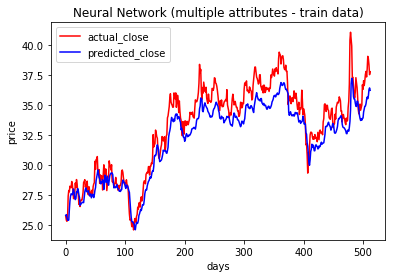

Loaded model from disk
feature: [1]
 r2_score: 0.9514340682098439
 mse_score: 0.6577044818809655



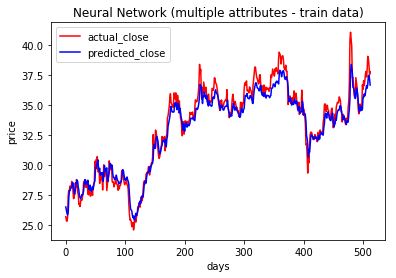

Loaded model from disk
feature: [2]
 r2_score: -22.58167048111321
 mse_score: 319.3549427339911



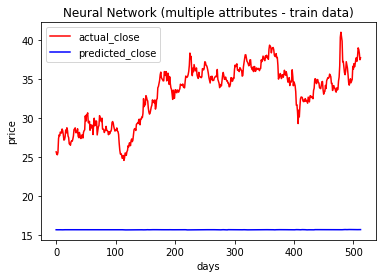

Loaded model from disk
feature: [3]
 r2_score: 0.8084125534832115
 mse_score: 2.5945743775837995



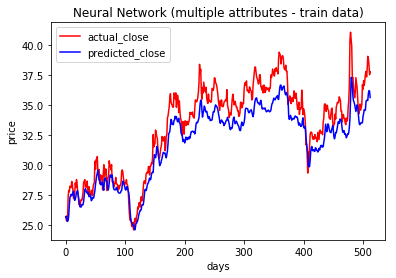

Loaded model from disk
feature: [0 1]
 r2_score: 0.9532280984440343
 mse_score: 0.6334088144827709



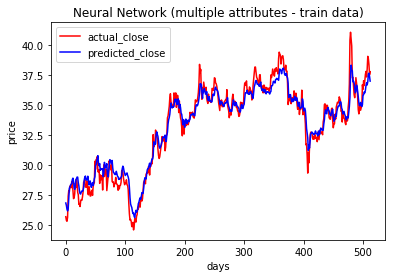

Loaded model from disk
feature: [0 2]
 r2_score: 0.91712190407538
 mse_score: 1.1223772123822753



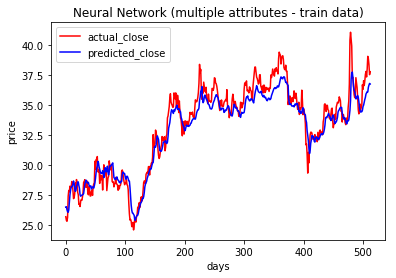

Loaded model from disk
feature: [0 3]
 r2_score: 0.9217109195389077
 mse_score: 1.0602304373379023



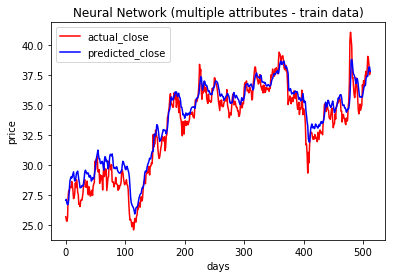

Loaded model from disk
feature: [1 2]
 r2_score: 0.8587339971865311
 mse_score: 1.9130958629452244



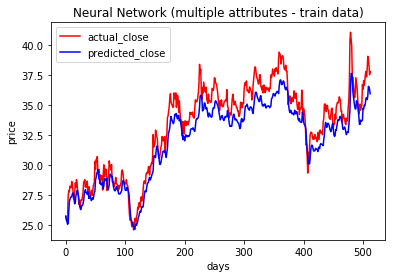

Loaded model from disk
feature: [1 3]
 r2_score: 0.9249456947757294
 mse_score: 1.0164234703403814



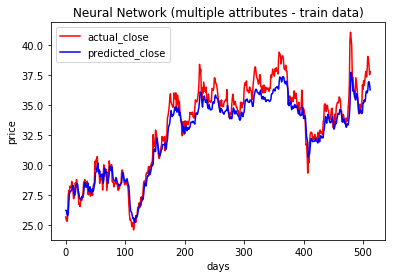

Loaded model from disk
feature: [2 3]
 r2_score: 0.8936473483481443
 mse_score: 1.4402815527885853



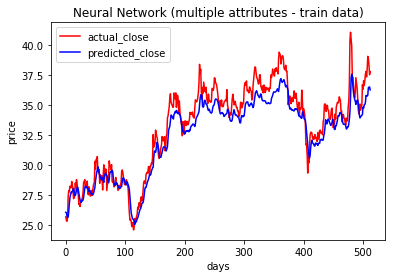

Loaded model from disk
feature: [0 1 2]
 r2_score: 0.7897649964483141
 mse_score: 2.8471090533514927



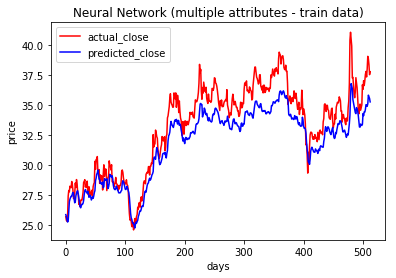

Loaded model from disk
feature: [0 1 3]
 r2_score: 0.8890415338480199
 mse_score: 1.5026558289073484



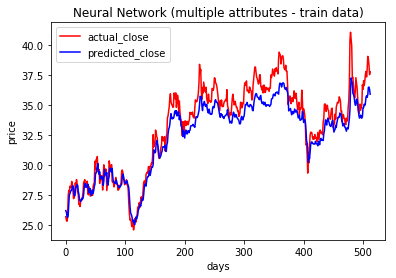

Loaded model from disk
feature: [0 2 3]
 r2_score: 0.8446239061950614
 mse_score: 2.1041818720623975



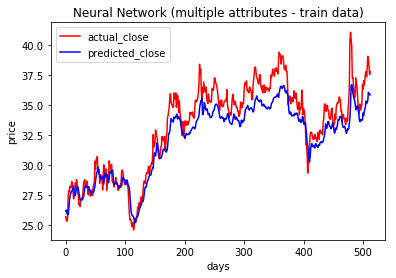

Loaded model from disk
feature: [1 2 3]
 r2_score: 0.8923312261249714
 mse_score: 1.4581051474974054



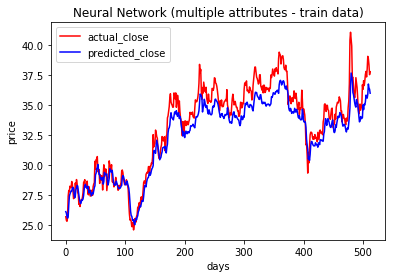

Loaded model from disk
feature: [0 1 2 3]
 r2_score: 0.9325221626409399
 mse_score: 0.9138190995788579



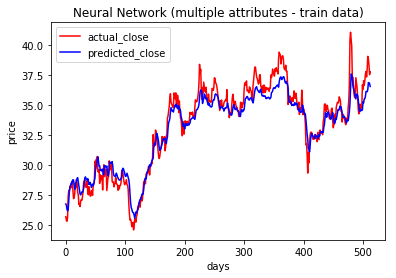

In [25]:
path_name = "./model/feature_importance" 
# actual output
test_actual = sc_output.inverse_transform(y_test)
# create dataframe for storing results
results = pd.DataFrame(columns=['feature_col', 'r2_score', 'mse_score'])
count = 0
for i in range(no_of_feature):
    for j in range(len(combination[i])):
        feature = np.array(combination[i][j])
        # load the model
        model = save_load.load_model(path_name + "/" + str(count))
        # predict
        pred_test_scaled = model.predict(X_test[:, :, feature])
        test_predict = sc_output.inverse_transform(pred_test_scaled)
        # evaluate
        model_accuracy_r2 = r2_score(test_actual, test_predict)
        model_accuracy_mse = mean_squared_error(test_actual, test_predict)
        print("feature: {}\n r2_score: {}\n mse_score: {}\n".format(feature, \
              model_accuracy_r2, model_accuracy_mse))
        plot.time_series_plot(test_actual, test_predict, 'red', 'blue', \
                              'actual_close', 'predicted_close', 'days', 'price',\
                              'Neural Network (multiple attributes - train data)')

        results.loc[count] = [feature, model_accuracy_r2, model_accuracy_mse]
        count = count + 1
# save to excel
results.to_excel("./result/feature_importance/result.xlsx")

In [29]:
'''
the final model of the stock price prediction using
results from hyperparameter optimization and feature importance. 

'''
# initiate
df_train = df[:int(len(df)*split_ratio)]
df_test = df[int(len(df)*split_ratio):]

# important parameters
columns = [4]
no_of_feature = 1
timestep = 60
input_col = [0]
output_col = [0]

# create minmax scaler object
input_set = df.iloc[:, columns].values
sc_input = MinMaxScaler(feature_range = (0,1))
sc_input.fit(input_set)
sc_output = MinMaxScaler(feature_range = (0,1))
sc_output.fit(input_set[:,output_col])

# create training set
training_set = df_train.iloc[:, columns].values
training_set_scaled = sc_input.transform(training_set)

X_train, y_train = tensor.create_tensor(training_set_scaled, timestep, input_col,\
                                        output_col, no_of_feature)

# create testing set
testing_set = df_test.iloc[:, columns].values
x1 = pd.DataFrame(training_set[len(training_set)-timestep:])
x2 = pd.DataFrame(testing_set)
testing_set = np.array(pd.concat([x1, x2]))
testing_set_scaled = sc_input.transform(testing_set)

X_test, y_test = tensor.create_tensor(testing_set_scaled, timestep, input_col, \
                                      output_col, no_of_feature)

Epoch 1/90
1992/1992 [==============================] - 24s 12ms/step - loss: 0.0057
Epoch 2/90
1992/1992 [==============================] - 9s 5ms/step - loss: 0.0017
Epoch 3/90
1992/1992 [==============================] - 10s 5ms/step - loss: 0.0014
Epoch 4/90
1992/1992 [==============================] - 10s 5ms/step - loss: 0.0014
Epoch 5/90
1992/1992 [==============================] - 10s 5ms/step - loss: 0.0014
Epoch 6/90
1992/1992 [==============================] - 10s 5ms/step - loss: 0.0018
Epoch 7/90
1992/1992 [==============================] - 10s 5ms/step - loss: 0.0016
Epoch 8/90
1992/1992 [==============================] - 10s 5ms/step - loss: 0.0012
Epoch 9/90
1992/1992 [==============================] - 10s 5ms/step - loss: 0.0012
Epoch 10/90
1992/1992 [==============================] - 10s 5ms/step - loss: 0.0011
Epoch 11/90
1992/1992 [==============================] - 10s 5ms/step - loss: 0.0011
Epoch 12/90
1992/1992 [==============================] - 10s 5ms/step - lo

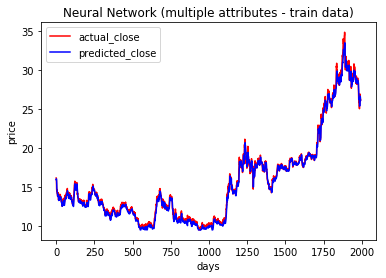

R2 Score :  0.8931458674517805
MSE Score :  1.4470728614479416


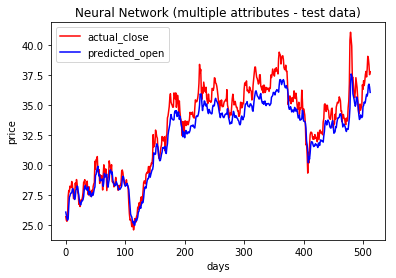

In [39]:
path_name = "./model/final_model"
# import tensorflow as tf
# import keras.backend.tensorflow_backend as KTF
# KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))
# train the model
# with tf.device('/cpu:0'):
model = train.training(X_train, y_train, no_of_feature, epochs, 'relu', 'adam')

# Save the model
save_load.save_model(path_name, model)

# load the model
model = save_load.load_model(path_name)

# prediction using train set
pred_train_scaled = model.predict(X_train)

# rescale the predictions with train data
train_predict = sc_output.inverse_transform(pred_train_scaled)
train_actual = sc_output.inverse_transform(y_train)

print('R2 Score : ', r2_score(train_actual, train_predict))
print('MSE Score : ', mean_squared_error(train_actual, train_predict))

plot.time_series_plot(train_actual, train_predict, 'red', 'blue', 'actual_close', \
                 'predicted_close', 'days', 'price', \
                 'Neural Network (multiple attributes - train data)')

# predict using testing set
pred_test_scaled = model.predict(X_test)

# rescale the predictions with test data
test_predict = sc_output.inverse_transform(pred_test_scaled)
test_actual = sc_output.inverse_transform(y_test)

print('R2 Score : ', r2_score(test_actual, test_predict))
print('MSE Score : ', mean_squared_error(test_actual, test_predict))

plot.time_series_plot(test_actual, test_predict, 'red', 'blue', 'actual_close', \
                 'predicted_open', 'days', 'price', \
                 'Neural Network (multiple attributes - test data)')

In [43]:
# save the final results in excel format
date = pd.DataFrame(df_test['date']).reset_index(drop=True)
actual_price_df = pd.DataFrame(test_actual).round(3)
predict_price_df = pd.DataFrame(test_predict).round(3)
combined_df = pd.concat([date, actual_price_df, predict_price_df], axis = 1)
combined_df.columns = ['date','actual_close', 'predicted_close']
combined_df.to_excel('./result/final_model/result.xlsx', index = False)